In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [2]:
transform = T.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

X = torch.stack([trainset[i][0] for i in range(10000)])   # [N,3,32,32]
Y = torch.tensor([trainset[i][1] for i in range(10000)])

patches = torch.nn.Unfold(kernel_size=3, padding=1)(X).permute(0,2,1)
patches = patches.reshape(-1, 27).numpy()   # (N * H*W) × 27


100%|██████████| 170M/170M [00:01<00:00, 91.2MB/s]


In [3]:
pca = PCA(n_components=27)
pca.fit(patches)

components = torch.tensor(pca.components_, dtype=torch.float32) # 27×27

# PCA Whitening: x' = l^{-1/2} U x
eps = 1e-5
Lambda = torch.tensor(pca.explained_variance_).float()
W_pca = torch.diag(1 / torch.sqrt(Lambda + eps)) @ components

# ZCA Whitening: x' = U l^{-1/2} U^T x
W_zca = components.T @ torch.diag(1 / torch.sqrt(Lambda + eps)) @ components


In [4]:
def whiten_images(X, W):
    # X: N×3×32×32
    unfold = torch.nn.Unfold(kernel_size=3, padding=1)
    fold = torch.nn.Fold(output_size=(32,32), kernel_size=3, padding=1)

    Xf = unfold(X).permute(0,2,1)    # N×1024×27
    Xw = Xf @ W.T                    # apply whitening
    Xw = Xw.permute(0,2,1)
    Xw = fold(Xw)
    return Xw

X_pca = whiten_images(X, W_pca)
X_zca = whiten_images(X, W_zca)
X_raw = X.clone()

X_raw  = X_raw.float()
X_pca  = X_pca.float()
X_zca  = X_zca.float()

Y = Y.long()


In [5]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 32, 3, padding=1)
        self.fc = nn.Linear(32*32*32, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)


def compute_energy_profile(model, components):
    '''
    Returns a 27d vector:
    energy of first-layer conv filter projected onto PCA components.
    '''
    W = model.conv.weight.data.clone()        # [32, 3, 3, 3]
    W = W.view(32, -1)                        # 32×27

    # Project each filter onto PCA basis:
    # energy[k] = sum_i (W_i · PCA_k)^2
    Wt = W @ components.T                    # 32×27
    energy = (Wt**2).sum(0)

    # normalize
    return (energy / energy.sum()).cpu().numpy()


def train_and_track(X, Y, label, steps=[0,5,50,500,2000]):
    model = SmallCNN()
    optim = torch.optim.SGD(model.parameters(), lr=0.01)
    loader = DataLoader(TensorDataset(X, Y), batch_size=128, shuffle=True)

    energies = {}
    step_counter = 0

    # Record initialization
    energies[0] = compute_energy_profile(model, components)

    for epoch in range(30):    # enough to reach convergence (and reach step 2000)
        for xb, yb in loader:
            optim.zero_grad()
            loss = F.cross_entropy(model(xb), yb)
            loss.backward()
            optim.step()

            step_counter += 1

            if step_counter in steps:
                energies[step_counter] = compute_energy_profile(model, components)
                print(f"\n[{label}] Step {step_counter} energy profile:")
                print(energies[step_counter])

            if step_counter > max(steps):
                return energies

    return energies


In [6]:
energies_raw = train_and_track(X_raw, Y, "raw")
energies_pca = train_and_track(X_pca, Y, "pca")
energies_zca = train_and_track(X_zca, Y, "zca")



[raw] Step 5 energy profile:
[0.06262536 0.03226269 0.03941541 0.02478745 0.03522575 0.05202002
 0.03920544 0.03450781 0.03636133 0.03703621 0.04409767 0.0256841
 0.03138938 0.02636319 0.03418761 0.03485348 0.03948205 0.0503809
 0.02834434 0.03091816 0.04278646 0.02916666 0.04335633 0.03579198
 0.03344833 0.04124726 0.03505462]

[raw] Step 50 energy profile:
[0.0633652  0.03220065 0.03917088 0.02779924 0.03511914 0.0517062
 0.03948717 0.03431085 0.03620919 0.03684966 0.04388439 0.02557912
 0.03123927 0.02624133 0.03404223 0.03469394 0.03931125 0.05014919
 0.02820814 0.03078165 0.04259136 0.02903119 0.04315644 0.03562726
 0.03329427 0.04105709 0.03489373]

[raw] Step 500 energy profile:
[0.06085867 0.0336235  0.03828879 0.05959641 0.0340077  0.04956378
 0.05736937 0.03208064 0.03457325 0.03435776 0.04110872 0.02421961
 0.02917554 0.02474514 0.03211989 0.03252988 0.03690343 0.04695335
 0.02623422 0.02882076 0.03983988 0.027161   0.04037244 0.03332533
 0.03114347 0.03839584 0.03263166]



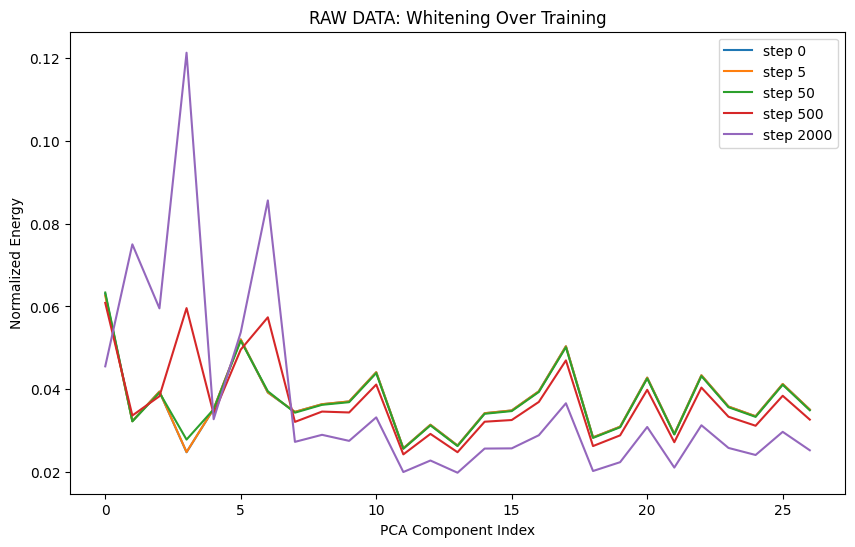

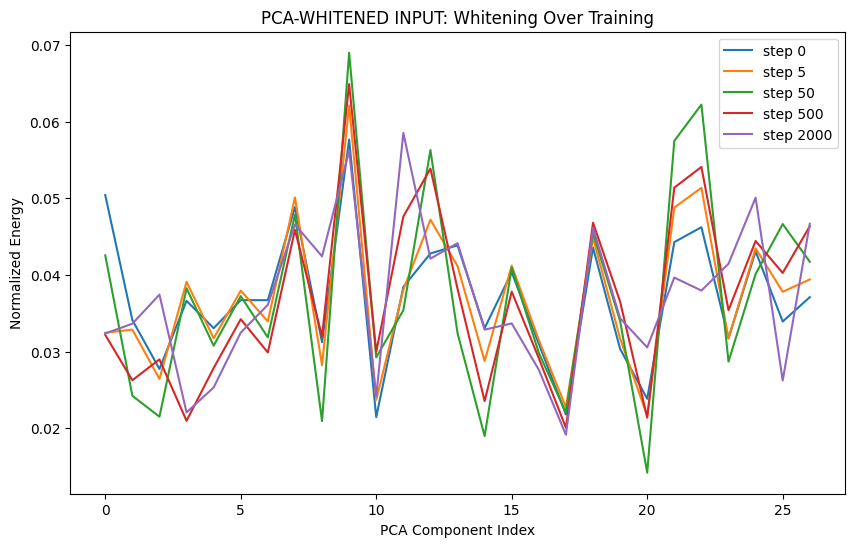

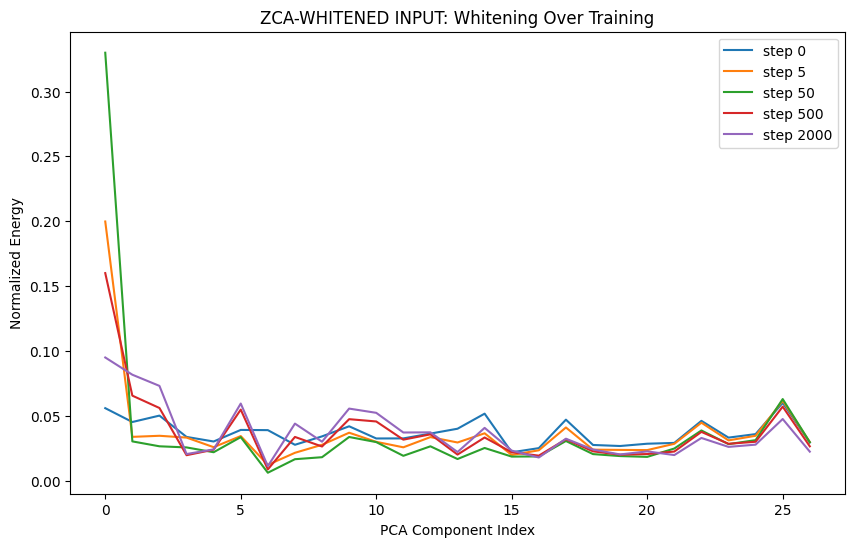

In [7]:
def plot_trajectories(energies, title):
    plt.figure(figsize=(10,6))

    for step, curve in energies.items():
        plt.plot(curve, label=f"step {step}")

    plt.title(title)
    plt.xlabel("PCA Component Index")
    plt.ylabel("Normalized Energy")
    plt.legend()
    plt.show()

plot_trajectories(energies_raw, "RAW DATA: Whitening Over Training")
plot_trajectories(energies_pca, "PCA-WHITENED INPUT: Whitening Over Training")
plot_trajectories(energies_zca, "ZCA-WHITENED INPUT: Whitening Over Training")
